# Libraries

In [74]:
import numpy as np
import pandas as pd
# sm - https://towardsdatascience.com/simple-and-multiple-linear-regression-in-python-c928425168f9
#import statsmodels as sm
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style="ticks", color_codes=True)
import graphviz

from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import Perceptron, LinearRegression, LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklear.utils import multiclass
#Which search to use?
from sklearn.model_selection import GridSearchCV#, RandomizedSearchCV
#For max_depth
from sklearn.tree import DecisionTreeClassifier, plot_tree

np.random.seed(50)

#Plotting Params

%matplotlib inline

#plt.rcParams['figure.figsize'] = [20.0, 7.0]
#plt.rcParams.update({'font.size': 22,})

#sns.set_palette('viridis')
#sns.set_style('white')
#sns.set_context('talk', font_scale=0.8)

In [51]:
#Get all data
data = pd.read_csv(r'assignment1-2019-data.csv')
from sklearn.datasets import load_digits, load_iris, load_breast_cancer, make_moons

digits = load_digits()
iris = load_iris()
breast_cancer = load_breast_cancer()

# Tuning Maximum Depth

- Adding an extra layer I considered to be worthwhile for a 2% improvement in accuracy
- As displayed in the breast_cancer case, there was a reduction in the accuracy before a large improvement which shows an interesting case which makes me question my rule
- Initially I tried to automate the depth selection of each dataset with my rule as above using the following code approximately. With a more robust algorithm, this type of approach would work.
~~~
exit = False
while not exit:
    value = classifier(digits, depth)
    if (value - prev) > 0.02:
        prev = value
        accuracy.append(value)
    else:
        exit = True
        accuracy.append(value)
        
    depth += 1
~~~


In [3]:
#test
#get_h_params(breast_cancer)

In [4]:
dataset = breast_cancer
#This will become a function
def classifier(dataset, depth):
    #Split into test and train 30:70
    n_samples = len(dataset.data)
    X = dataset.data.reshape((n_samples, -1))
    y = dataset.target
    X_train_dataset, X_test_dataset, y_train_dataset, y_test_dataset = train_test_split(X, y, test_size=0.30, random_state=50)
    #print(len(X_train_dataset), len(X_test_dataset))

    #K-fold on training data
    kf_data = KFold(n_splits = 6)
    for train_index, test_index in kf_data.split(X_train_dataset):
        #print("TRAIN:", train_index, "\n", "TEST:", test_index)
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        #Classification
        estimator = DecisionTreeClassifier(random_state=50, max_depth=depth) #max_depth global
        estimator.fit(X_train, y_train)

        #Tree structure arrays
        n_nodes = estimator.tree_.node_count
        children_left = estimator.tree_.children_left #id of left children
        children_right = estimator.tree_.children_right #id of right children
        feature = estimator.tree_.feature #feature used for splitting node
        threshold = estimator.tree_.threshold #thsh value at the node

        #i = 0
        #for X in X_test_dataset:
            #y = y_test_dataset[i]
            #prediction = predict(X)
            #print(prediction, y)
            #i+=1

        #Plot
        plot_tree(estimator.fit(dataset.data, dataset.target), filled = True, rounded = True)
        #dot_data = export_graphviz(clf, out_file=None)
        #graph = graphviz.Source(dot_data)
        #graph.render("digits")

        #accuracy = accuracy_score(y_true, y_pred)
    return(estimator.score(X_test_dataset, y_test_dataset))

    Accuracy
0   0.688889
1   0.977778
2   0.977778
3   1.000000
4   1.000000
5   1.000000
6   1.000000
7   1.000000
8   1.000000
9   1.000000
10  1.000000


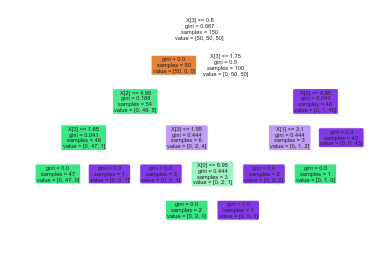

In [5]:
#Iris
exit = False
depth = 1
prev = 0
accuracy = []
while depth <= 11:
    value = classifier(iris, depth)
    accuracy.append(value)
        
    depth += 1
data = pd.DataFrame(accuracy, columns = ['Accuracy'])
print(data)

    Accuracy
0   0.935673
1   0.906433
2   0.988304
3   0.988304
4   0.994152
5   1.000000
6   1.000000
7   1.000000
8   1.000000
9   1.000000
10  1.000000


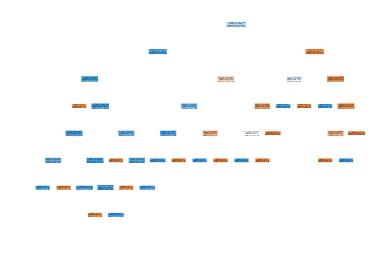

In [6]:
#Breast Cancer
exit = False
depth = 1
prev = 0
accuracy = []
while depth <= 11:
    value = classifier(breast_cancer, depth)
    accuracy.append(value)
        
    depth += 1
data = pd.DataFrame(accuracy, columns = ['Accuracy'])
print(data)

    Accuracy
0   0.222222
1   0.342593
2   0.488889
3   0.596296
4   0.709259
5   0.814815
6   0.881481
7   0.927778
8   0.964815
9   0.987037
10  0.994444


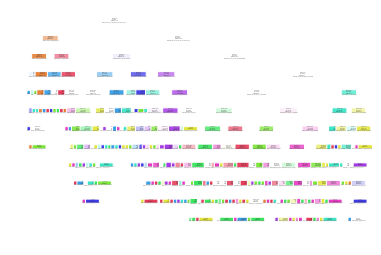

In [7]:
#Digits
exit = False
depth = 1
prev = 0
accuracy = []
while depth <= 11:
    value = classifier(digits, depth)
    accuracy.append(value)
        
    depth += 1
data = pd.DataFrame(accuracy, columns = ['Accuracy'])
print(data)

# DT vs Linear Models

- The performance of the decision tree worsens as it continues to overfit where, in fact, a lot of its fitting is fitting a noisey point. In comparrison, the linear model just approximates how the data is split.
- If this problem was in Rd instead of R2, it would create d-dimentional boundries and overfit the data as it does in R2.
- Created a dataset using sklearns make_moons
- Used a decision boundary plotting function created by Mark Danovich, found online. 

The graphs show the original data (top), the linear regression (middle) and the decision tree at a depth of 10.

In [30]:
#Edited from https://markd87.github.io/articles/ml.html
def plot_decision_boundary(model,X,y):
    padding=0.15
    res=0.01
    
    #max and min values of x and y of the dataset
    x_min,x_max=X[:,0].min(), X[:,0].max()
    y_min,y_max=X[:,1].min(), X[:,1].max()
    
    #range of x's and y's
    x_range=x_max-x_min
    y_range=y_max-y_min
    
    #add padding to the ranges
    x_min -= x_range * padding
    y_min -= y_range * padding
    x_max += x_range * padding
    y_max += y_range * padding

    #create a meshgrid of points with the above ranges
    xx,yy=np.meshgrid(np.arange(x_min,x_max,res),np.arange(y_min,y_max,res))
    
    #use model to predict class at each point on the grid
    #ravel turns the 2d arrays into vectors
    #c_ concatenates the vectors to create one long vector on which to perform prediction
    #finally the vector of prediction is reshaped to the original data shape.
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])   
    Z = Z.reshape(xx.shape)
    
    #plot the contours on the grid
    plt.figure(figsize=(8,6))
    cs = plt.contourf(xx, yy, Z, cmap=plt.cm.PiYG)
    
    #plot the original data and labels
    plt.scatter(X[:,0], X[:,1], s=35, c=y, cmap=plt.cm.seismic)

depth = 1
DT accuracy = 0.685
None
depth = 2
DT accuracy = 0.72
None
depth = 3
DT accuracy = 0.72
None
depth = 4
DT accuracy = 0.725
None
depth = 5
DT accuracy = 0.69
None
depth = 6
DT accuracy = 0.67
None
depth = 7
DT accuracy = 0.635
None
depth = 8
DT accuracy = 0.66
None
depth = 9
DT accuracy = 0.655
None
depth = 10
DT accuracy = 0.665
None
Linear accuracy = 0.735
DT accuracy = 0.665
DT accuracy = 0.665


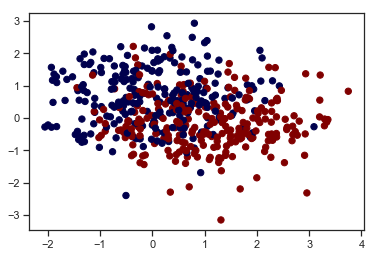

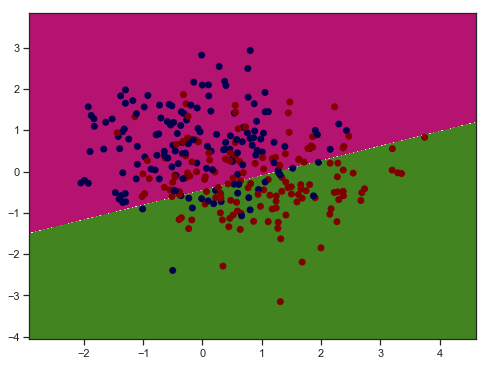

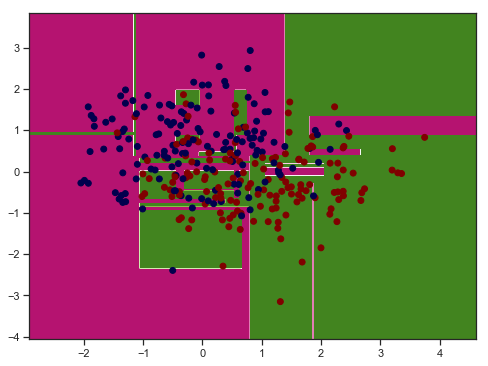

In [66]:
X,y = make_moons(500, noise=0.8, random_state=50)

#Split data
#n_samples = len(dataset.data)
#X = dataset.data[50:, (0, 1)]
#y = dataset.target[50:]
X_train_dataset, X_test_dataset, y_train_dataset, y_test_dataset = train_test_split(X, y, 
                                                        test_size=0.4, random_state=50) 
plt.scatter(X[:,0], X[:,1], s=40, c=y, cmap=plt.cm.seismic)
#Train
def formula(depth, prnt = False):
    linear = Perceptron(random_state=50)
    linear.fit(X_train_dataset, y_train_dataset)
    z1 = linear.fit(X_train_dataset, y_train_dataset)
    score_linear = linear.score(X_test_dataset, y_test_dataset)
    if prnt == True:
        print("Linear accuracy =", score_linear)
        plot_decision_boundary(z1, X_train_dataset, y_train_dataset)

    dt = DecisionTreeClassifier(random_state=50, max_depth = depth)
    dt.fit(X_train_dataset, y_train_dataset)
    z2 = dt.fit(X_train_dataset, y_train_dataset)
    score_dt = dt.score(X_test_dataset, y_test_dataset)
    print("DT accuracy =", score_dt)
    if prnt == True:
        print("DT accuracy =", score_dt)
        plot_decision_boundary(z2, X_train_dataset, y_train_dataset)
    
for i in range(10):
    print("depth =",(i+1))
    print(formula(i+1))
formula(10, prnt=True)


#Test training

# Regression on Mixed Data Types

- Given data set for a regression problem
- Need to train linear regression model
- Needs to be linear in weights and features 
- Has a categorical feature with more than two levels
- Use entire dataset for training
- Needs to output
    - Mean Squared Error
    - R^2
    - Round coefficients to intigers
    - Write a case based definition of the functions identified
        - Linear expression of input variables
        - One expression per level of variable
    - Describe how regression was used
    - How a new datapoint can be assigned a predicted value

In [98]:
#Code for Regression goes here.
dataset = pd.read_csv('assignment1-2019-data.csv')
X = dataset.drop('Y', axis=1)
y = dataset['Y']
#Don't split data, train on all
numeric_features = ['X1', 'X2', 'X3']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_features = ['X4']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', LogisticRegression())])

clf.fit(X, y)
print(clf.score(X,y))

/Users/Bingham/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


ValueError: Unknown label type: 'continuous'